In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import collections
import copy
from functools import partial
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy as sp
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
#from pyDOE2 import lhs
from scipy.stats.distributions import norm

Pour l'implementation de Lime. Nous avons repris la fonction de tirage de point du papier et nous l'avons simplifié pour garder un cas de tirage sur une gaussienne. 
Nous avons aussi repris la fonction Kernel qui sert à gerer le tirage des données pour l'echantillonage

In [29]:
# echantillonage comme sur le papier le LIME ( simplification de la fonction pour prendre un seul cas ).

def data_inverse(data_row,num_samples):
        """Generates a neighborhood around a prediction.
        For numerical features, perturb them by sampling from a Normal(0,1) and
        doing the inverse operation of mean-centering and scaling, according to
        the means and stds in the training data. For categorical features,
        perturb by sampling according to the training distribution, and making
        a binary feature that is 1 when the value is the same as the instance
        being explained.
        Args:
            data_row: 1d numpy array, corresponding to a row
            num_samples: size of the neighborhood to learn the linear model
            sampling_method: 'gaussian' or 'lhs'
        Returns:
            A tuple (data, inverse), where:
                data: dense num_samples * K matrix, where categorical features
                are encoded with either 0 (not equal to the corresponding value
                in data_row) or 1. The first row is the original instance.
                inverse: same as data, except the categorical features are not
                binary, but categorical (as the original data)
        """
        is_sparse = sp.sparse.issparse(data_row)
        #print(is_sparse)
        num_cols = data_row.shape[0]
        #num_cols = 4

        #print(num_cols)
        data = sp.sparse.csr_matrix((num_samples, num_cols), dtype=data_row.dtype)
        inverse = data.copy()
        categorical_features = range(num_cols)

        instance_sample = data_row
       # print(data_row)
        scale = np.ones(num_cols)
        mean = np.zeros(num_cols)
        non_zero_indexes = data_row.nonzero()[0]
        #print(non_zero_indexes)
        num_cols = len(non_zero_indexes)
        instance_sample = data_row[non_zero_indexes]
        scale = scale[non_zero_indexes]
        mean = mean[non_zero_indexes]
        data = np.random.normal(0, 1, num_samples * num_cols).reshape(num_samples, num_cols)
        #print(data)
        data = np.array(data)
        data = data * scale + instance_sample
        if num_cols == 0:
            data = sp.sparse.csr_matrix((num_samples,
                                                 data_row.shape[0]),
                                                dtype=data_row.dtype)
        
        indexes = np.tile(non_zero_indexes, num_samples)
        indptr = np.array(range(0, len(non_zero_indexes) * (num_samples + 1),len(non_zero_indexes)))
        data_1d_shape = data.shape[0] * data.shape[1]
        data_1d = data.reshape(data_1d_shape)
        data = sp.sparse.csr_matrix((data_1d, indexes, indptr), shape=(num_samples, data_row.shape[0]))
        first_row = data_row
        data[0] = data_row.copy()
        inverse = data.copy()
        
        inverse[0] = data_row
        return data, inverse


In [30]:
def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

# Traitement des données

In [31]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
feature_names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker']
full_feature_names = [
    "checking account status",
    "duration",
    "credit history",
    "purpose",
    "credit amount",
    "savings account/bonds",
    "present employment since",
    "installment rate in percentage of disposable income",
    "personal status and sex",
    "other debtors/garantors",
    "present residence since",
    "property",
    "age in years",
    "other installment plans",
    "housing",
    "number of existing credits at this bank",
    "job",
    "number of people being liable to provide maintenance for",
    "telephone",
    "foreign worker"
]

In [47]:
data = pd.read_csv(
    "./german.data",
    header=None,
    sep=' ',
    engine='python',
    names=names
)
print(data.shape)

(1000, 21)


In [33]:
#print(data.iloc[0])

In [34]:
np_data = data.to_numpy()

In [35]:
categorical_features = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

In [36]:
numerical_data = np_data.copy()
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(numerical_data[:, feature])
    numerical_data[:, feature] = le.transform(numerical_data[:, feature])
    categorical_names[feature] = le.classes_

In [37]:
#print(numerical_data.shape)
#print(numerical_data)
X = numerical_data[:, 0:20]
#print(X.shape)
#print(X)
Y=numerical_data[:, [20]]
Y=Y.flatten()
for i in range(len(Y)):
    if Y[i]==1:
        Y[i]=0
    if Y[i]==2:
        Y[i]=1
#print(Y)
Y=Y.astype('int')


In [38]:
#creation donnée test
sm = SMOTE(random_state=42)
Xnorm= preprocessing.normalize(X, axis=0)
bruit = np.random.normal(0, 1, Xnorm.shape)
faussedonnée =bruit
Xfin,Yfin=sm.fit_resample(X, Y)
print(Xfin.shape)
print(Yfin.shape)
X_train, X_test, y_train, y_test = train_test_split(Xfin, Yfin, test_size=0.2, random_state=42)

(1400, 20)
(1400,)


# Modele echaffaudage 

Dans cette partie, on créer un modele echaffaud comme dans le cours. En cas de detection de Lime. Il va faire un tirage 50/50 pour savoir quelle classe renvoyer

In [39]:
def echaffaudage_model(x,y):
    # normalisation des donnée
    #print(normalizedx)
    #creation du model 
    model=RandomForestClassifier()
    model.fit(x,y)
    #generation des données simumlé 
    mu, sigma = 0, 1
    bruit = np.random.normal(mu, sigma, x.shape) # 50% donées simulé, 50% donnée reel
    donnéebruite = x + bruit
    ybruite=np.zeros(len(donnéebruite))# y des données bruites
    y2=np.ones(len(x))# y des données rééls
    yfinal=np.append(y2,ybruite)# merge
    #print(yfinal)
    normalizedx=np.vstack((x,donnéebruite))# merge des x
    #print(normalizedx.shape)
    yfinal=yfinal.astype('int')
    modeldetection=RandomForestClassifier()
    modeldetection.fit(normalizedx,yfinal)
    return model,modeldetection

In [40]:
def predictmodel(x,model,modeldetection):
    resultat=[]
    #normalizedx= preprocessing.normalize(x, axis=0)
        #print(newx)
    #print(newx)
    #print(x)
    for i in x:
        y=modeldetection.predict(i.reshape(1, -1))

        if y==1:# Si le point est un point original. On applique le classifieur
            #print("la")
            resultat.append(model.predict(x)[0])
        else:# on tire au hasard la valeur à renvoye(50-50)
            c=np.random.rand()
            if c>0.5:
                resultat.append(0)
            else:
                resultat.append(1)
    return resultat

In [41]:
model1,model2=echaffaudage_model(X_train,y_train)

In [42]:
for i in range(10):# test sur une vrai donné
    print(predictmodel(X_train[0].reshape(1, -1),model1,model2))

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [43]:
for i in range(10):# test sur une fausse donnée
    print(predictmodel(faussedonnée[2].reshape(1, -1),model1,model2))

[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]


# Test de LIME avec nos deux modeles

In [44]:
def Lime(model, x,nbfeatures,feature_names,plot=True):
    
    """input:
    - model: classifier to consider
    - nbmot: number of words to omit
    - text: input text
    output: none (printed values, and bar graph below)
    """
    #y=model.predict(x.reshape(1, -1))# 
    Zglobal,vv=data_inverse(x,3000)
    #print(Zglobal)
    Zglobal=pd.DataFrame(Zglobal.toarray())
    Zglobal=Zglobal.to_numpy()# Creation des points autour d'une loi normal (0,1)
    #print(Zglobal)
    distance=[]
    YZglobal=model.predict(Zglobal)
    if 1 and 0 in YZglobal  :# cas ou on ne trouve que des points de la meme classe ( diminue quand on augmente le nb de point sample
    #print(YZglobal)
        for i in range(len(Zglobal)):# parcouer des points
            distance.append(np.linalg.norm(Zglobal[i] - x))# calcul de la distance
        # plot de l'iteration
    #print(YZglobal.shape)
    #print(Zglobal.shape)
    
        poidtabular=np.sqrt(Zglobal.shape[1]) * .75
        poidtabularfin = partial(kernel, kernel_width=poidtabular)# creation de la ponderation pour LIMEtabular(present dans le papier)
        weight=[]
        for i in distance:
            weight.append(poidtabularfin(i))
    #print(weight)
  
    #print(Zglobal)
    #print(YZglobal)
    #print(weight)
        clf = LogisticRegression(random_state=0).fit(Zglobal,YZglobal,weight)# creation d'un classifieur ( regression logistique)
        poidregression=clf.coef_# recupere les poids
    #print(poidregression)
    
        poidbis=np.abs(poidregression)# valeur absolue
    #print(poidbis)
        valeurmax= np.argsort(poidbis, axis=1)#sort les index triés
        motprincipaux=[]
        valeurmot=np.zeros(nbfeatures)
    #print(valeurmot)
        for i in range(nbfeatures):# recupere les meilleurs indices
            indice=valeurmax[0][-i-1]
        #print(indice)
            valeurmot[i]=(poidregression[0][indice])
            motprincipaux.append(feature_names[indice])
    #print(motprincipaux)
    #print(valeurmot)
           #création de l'histogramme final
        x, y = valeurmot, motprincipaux
        if plot:
            plt.figure(figsize=(35,35))
            plt.bar(y, x)
            plt.title("feature important dans la classification de l'exemple")
            plt.show()
        return x,y # on renvoit les points et les colonnes selectionné
    else: 
        print("pas trouvé de points")
        return "pastrouve","pastrouve"

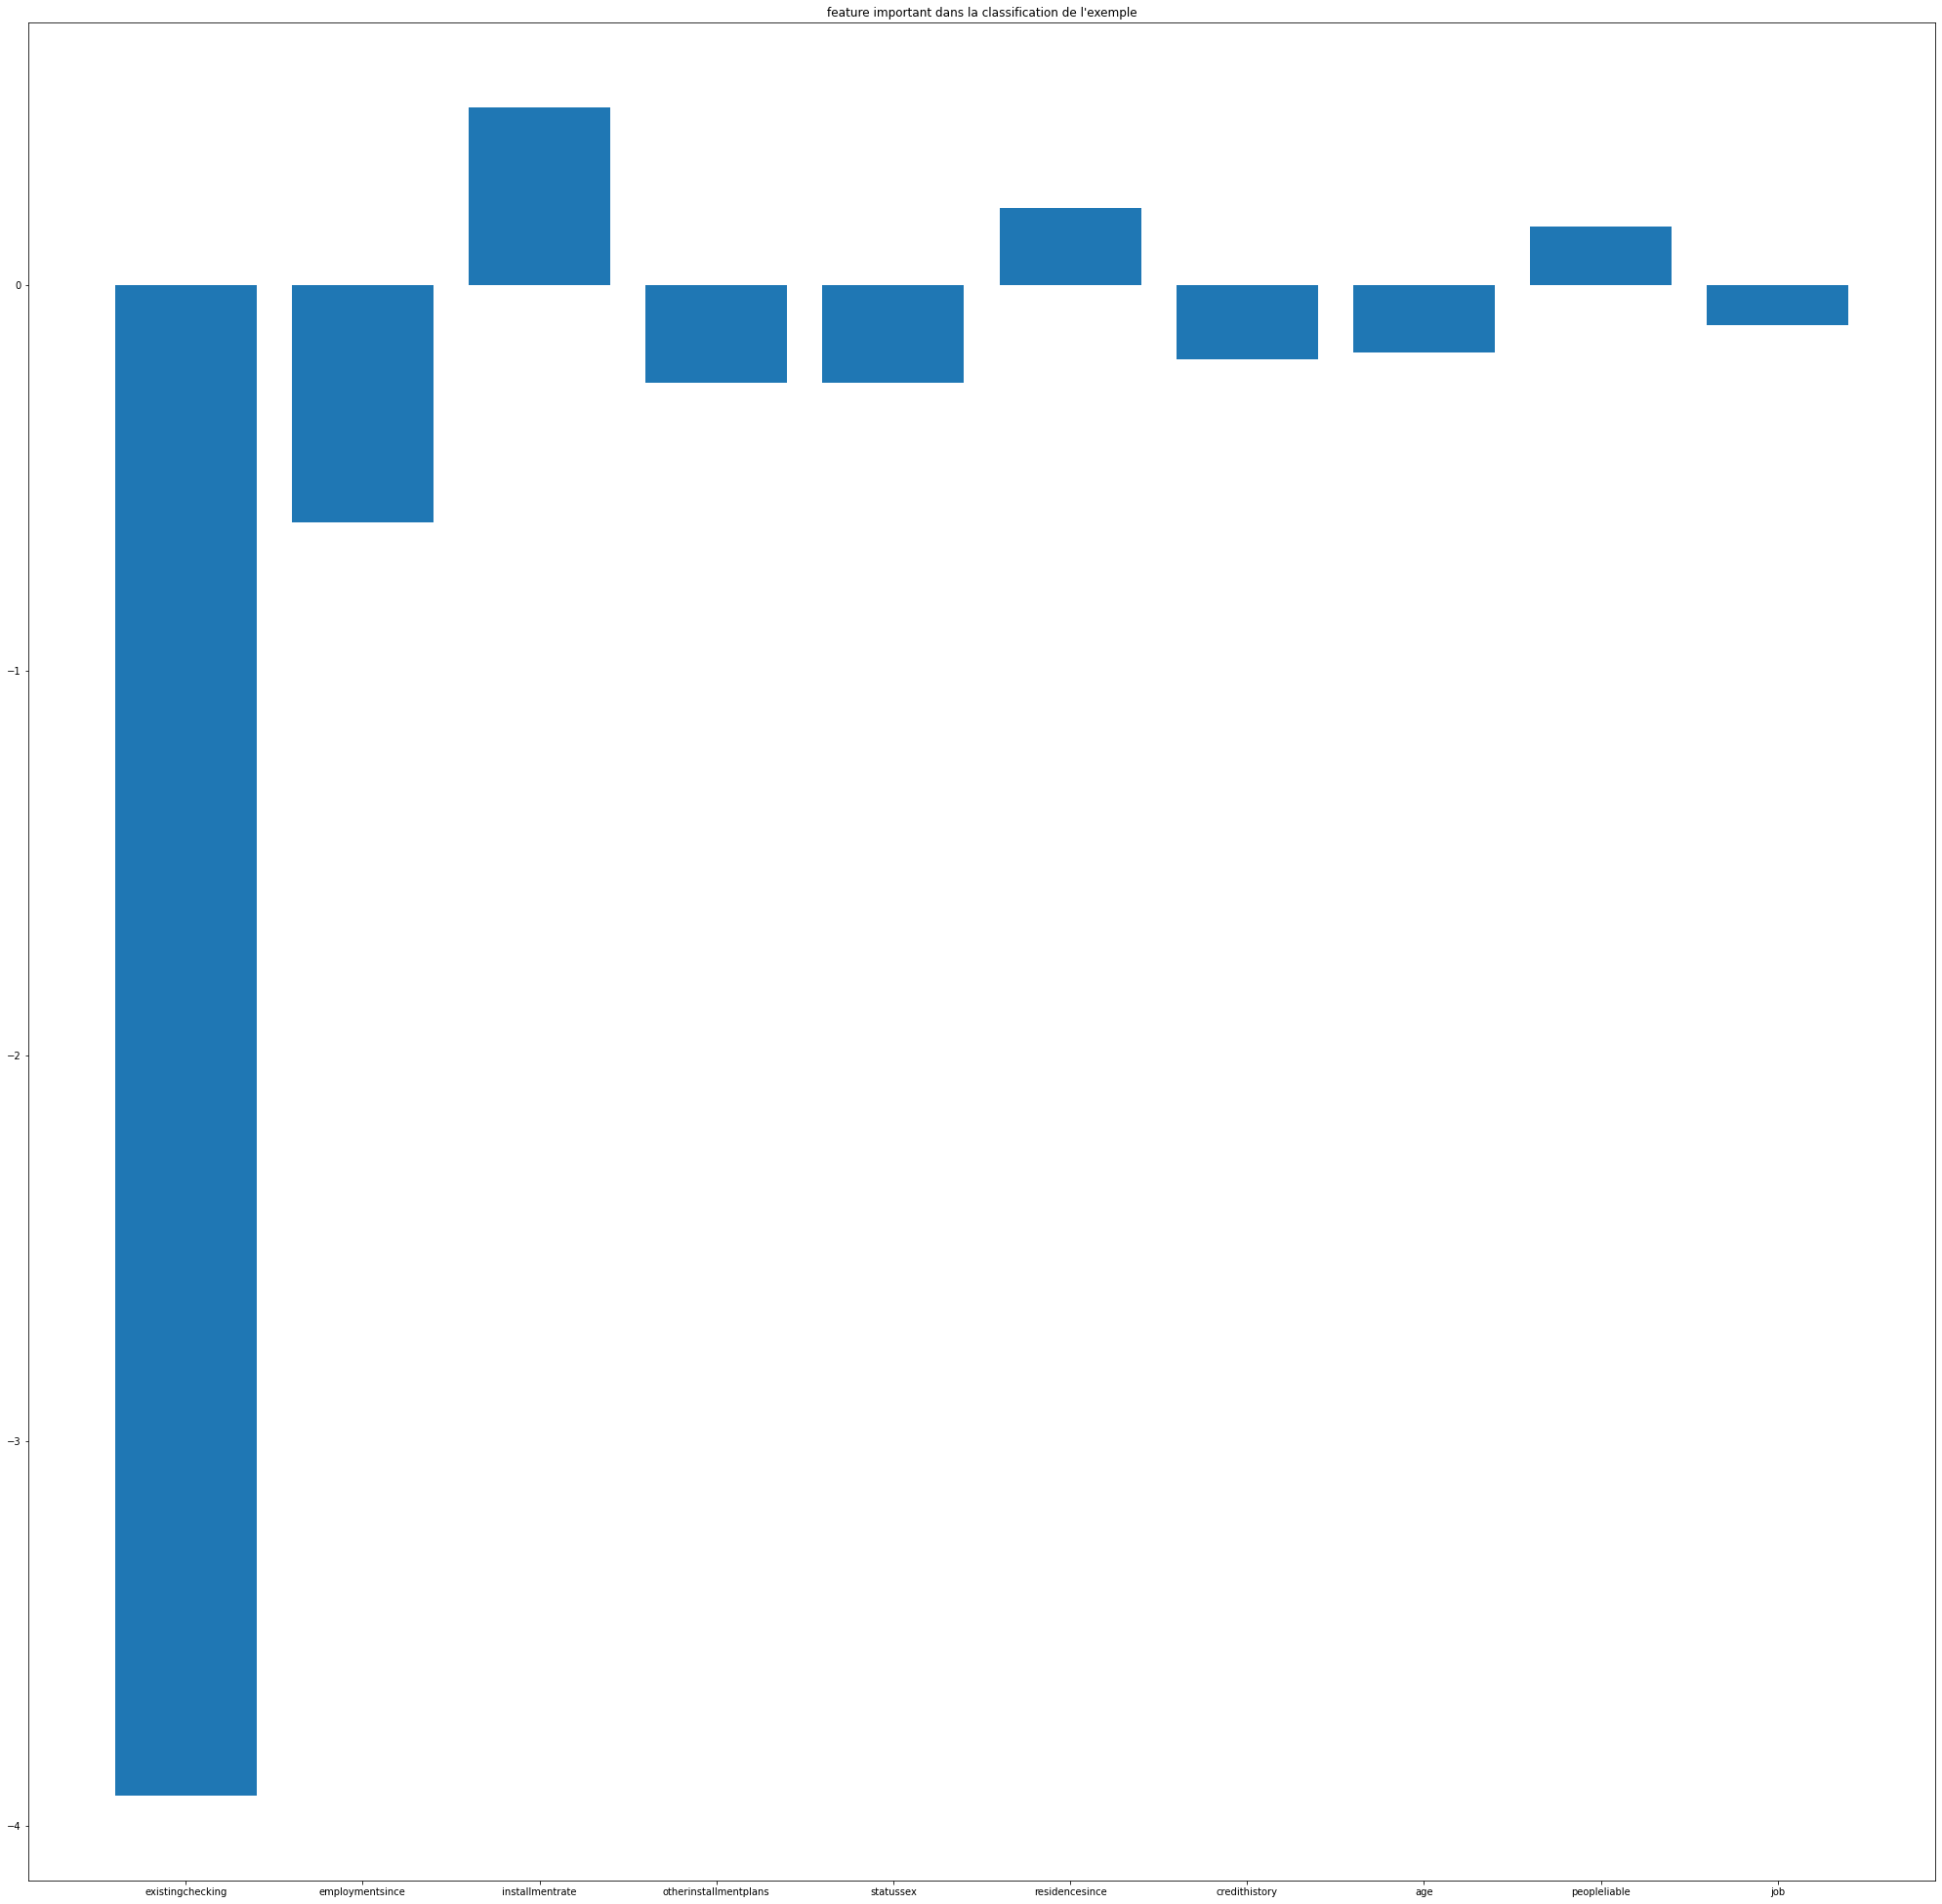

In [45]:
x,y=Lime(model1,X_test[5],10,feature_names,plot=True)# test sur un point


# Test sur l'ensemble de données Test

In [58]:

ytotal=feature_names
#print(ytotal)
xtotal=np.zeros(len(feature_names))
v=0
for i in X_test:
    x,y=Lime(model1,i,20,feature_names,plot=False)
    
    #print(x)
    if x !="pastrouve":
        for w in range(len(y)):
            for j in range(len(ytotal)):
                if y[w]==ytotal[j]:
                    xtotal[j]+=x[w]
    

pas trouvé de points


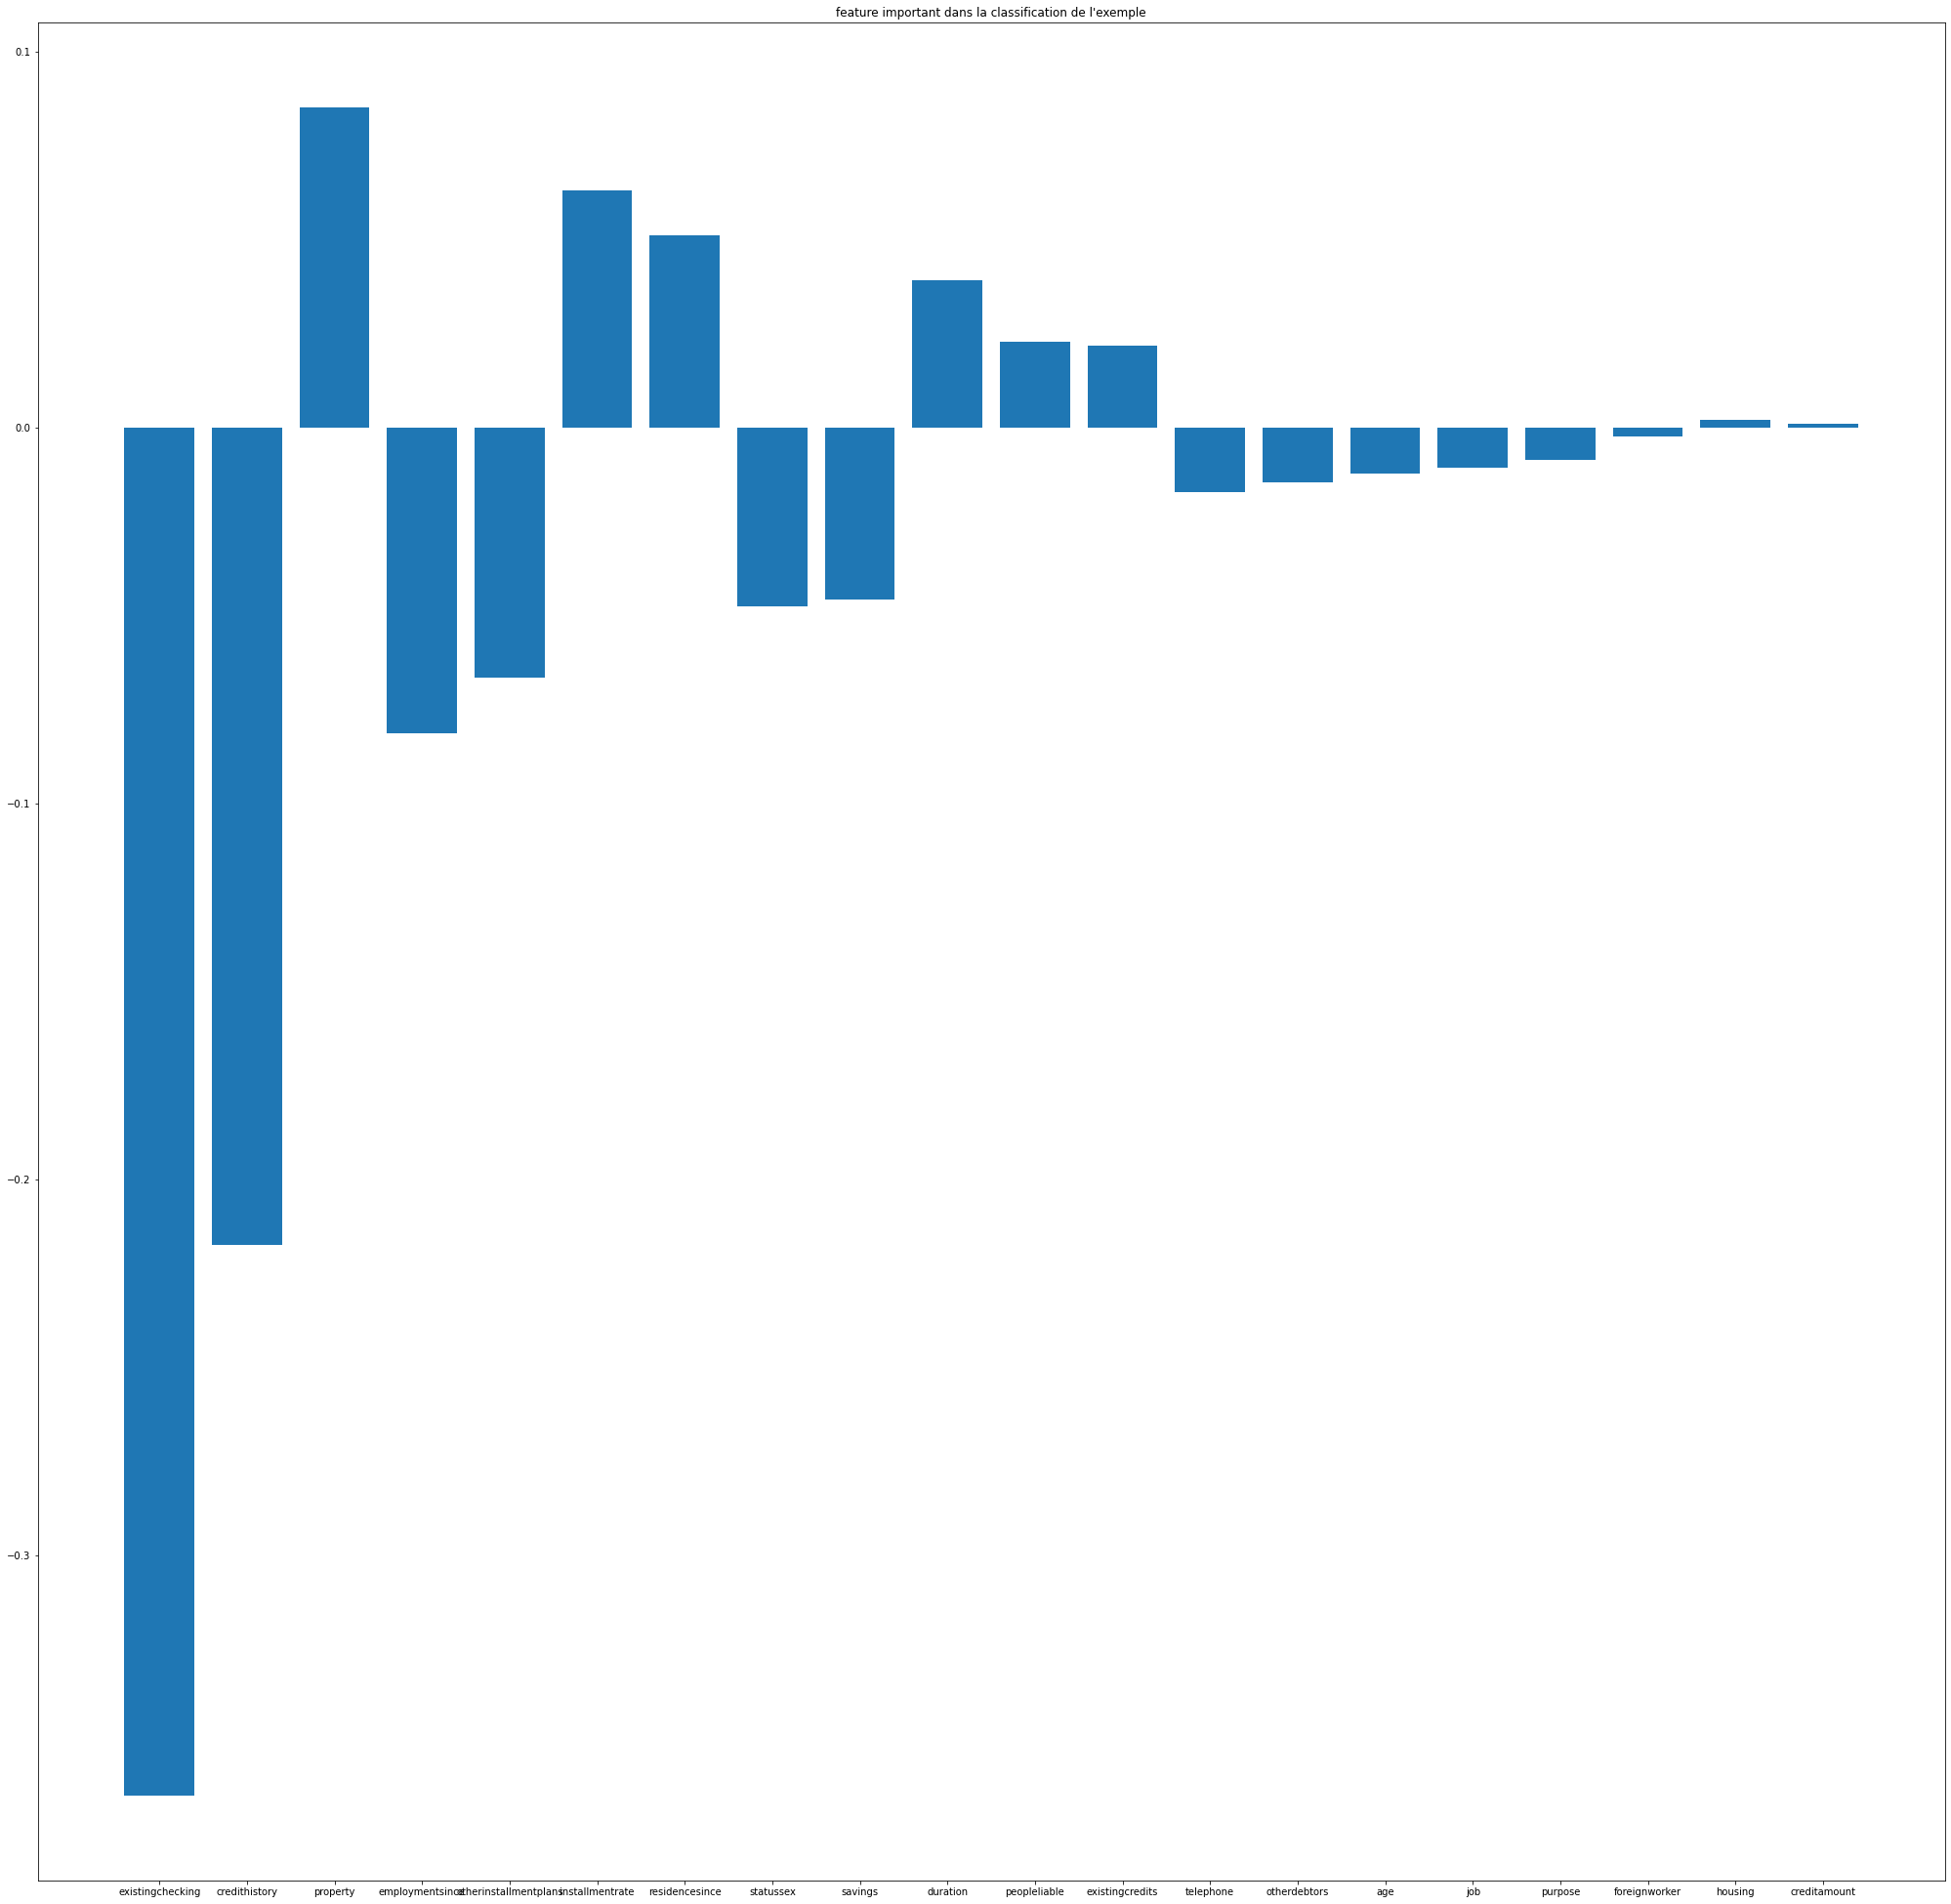

In [59]:
xx=[]
yy=[]
#print(xtotal/len(Xnorm))
#print(ytotal)
xtotnorm=xtotal/len(Xnorm)
featuremax= np.argsort(np.abs(xtotnorm), axis=0)#sort les index triés
#print(featuremax)
for i in range(len(featuremax)):
    
    #print(ytotal[featuremax[-i-1]])
    #print(xtotnorm[featuremax[-i-1]])
    xx.append(xtotnorm[featuremax[-i-1]])
    yy.append(ytotal[featuremax[-i-1]])
#print(xx)
#print(yy)
plt.figure(figsize=(40,40))
plt.bar(yy, xx)
plt.title("feature important dans la classification de l'exemple")
plt.show()

Lime nous renvoie des resultats.Cependant, ce n'est pas les mêmes que sur le papier 

# Test avec le modele echaffaudage ( long à executer , il faut verifier les conditions pour chaque points)

Pour cette fonction ,je suis oblige de remettre les données d'entrainement. Si je devais deployer cela, j'aurai créer un bjet classifieur avec mes données dedans. Lime se fait evidemment sans les données d'apprentissages

In [60]:
#On change juste la fonction de predict 
def Limeechaffaudage(model,model1, x,nbfeatures,feature_names,plot=True):
    
    """input:
    - model: classifier to consider
    - nbmot: number of words to omit
    - text: input text
    output: none (printed values, and bar graph below)
    """
    #y=model.predict(x.reshape(1, -1))# 
    Zglobal,vv=data_inverse(x,1000)
    #print(Zglobal)
    Zglobal=pd.DataFrame(Zglobal.toarray())
    Zglobal=Zglobal.to_numpy()# Creation des points autour d'une loi normal (0,1)
    #print(Zglobal)
    distance=[]
    YZglobal=predictmodel(Zglobal,model1,model2)
    if 1 and 0 in YZglobal  :# cas ou on ne trouve que des points de la meme classe ( diminue quand on augmente le nb de point sample
    #print(YZglobal)
        for i in range(len(Zglobal)):# parcouer des points
            distance.append(np.linalg.norm(Zglobal[i] - x))# calcul de la distance
        # plot de l'iteration
    #print(YZglobal.shape)
    #print(Zglobal.shape)
    
        poidtabular=np.sqrt(Zglobal.shape[1]) * .75
        poidtabularfin = partial(kernel, kernel_width=poidtabular)# creation de la ponderation pour LIMEtabular(present dans le papier)
        weight=[]
        for i in distance:
            weight.append(poidtabularfin(i))
    #print(weight)
  
    #print(Zglobal)
    #print(YZglobal)
    #print(weight)
        clf = LogisticRegression(random_state=0).fit(Zglobal,YZglobal,weight)# creation d'un classifieur ( regression logistique)
        poidregression=clf.coef_# recupere les poids
    #print(poidregression)
    
        poidbis=np.abs(poidregression)# valeur absolue
    #print(poidbis)
        valeurmax= np.argsort(poidbis, axis=1)#sort les index triés
        motprincipaux=[]
        valeurmot=np.zeros(nbfeatures)
    #print(valeurmot)
        for i in range(nbfeatures):# recupere les meilleurs indices
            indice=valeurmax[0][-i-1]
        #print(indice)
            valeurmot[i]=(poidregression[0][indice])
            motprincipaux.append(feature_names[indice])
    #print(motprincipaux)
    #print(valeurmot)
           #création de l'histogramme final
        x, y = valeurmot, motprincipaux
        if plot:
            plt.figure(figsize=(35,35))
            plt.bar(y, x)
            plt.title("feature important dans la classification de l'exemple")
            plt.show()
        return x,y # on renvoit les points et les colonnes selectionné
    else: 
        print("pas trouvé de points")
        return None,None

In [61]:
ytotal=feature_names
#print(ytotal)
xtotal=np.zeros(len(feature_names))
v=0
print(len(X_test))
for i in X_test:
    x,y=Limeechaffaudage(model1,model2,i,20,feature_names,plot=False)
    #print(x)
    if v%10==0:
        print(v)
    v+=1
    if type(x)!=None:
        for w in range(len(y)):
            for j in range(len(ytotal)):
                if y[w]==ytotal[j]:
                    xtotal[j]+=x[w]
    

280
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270


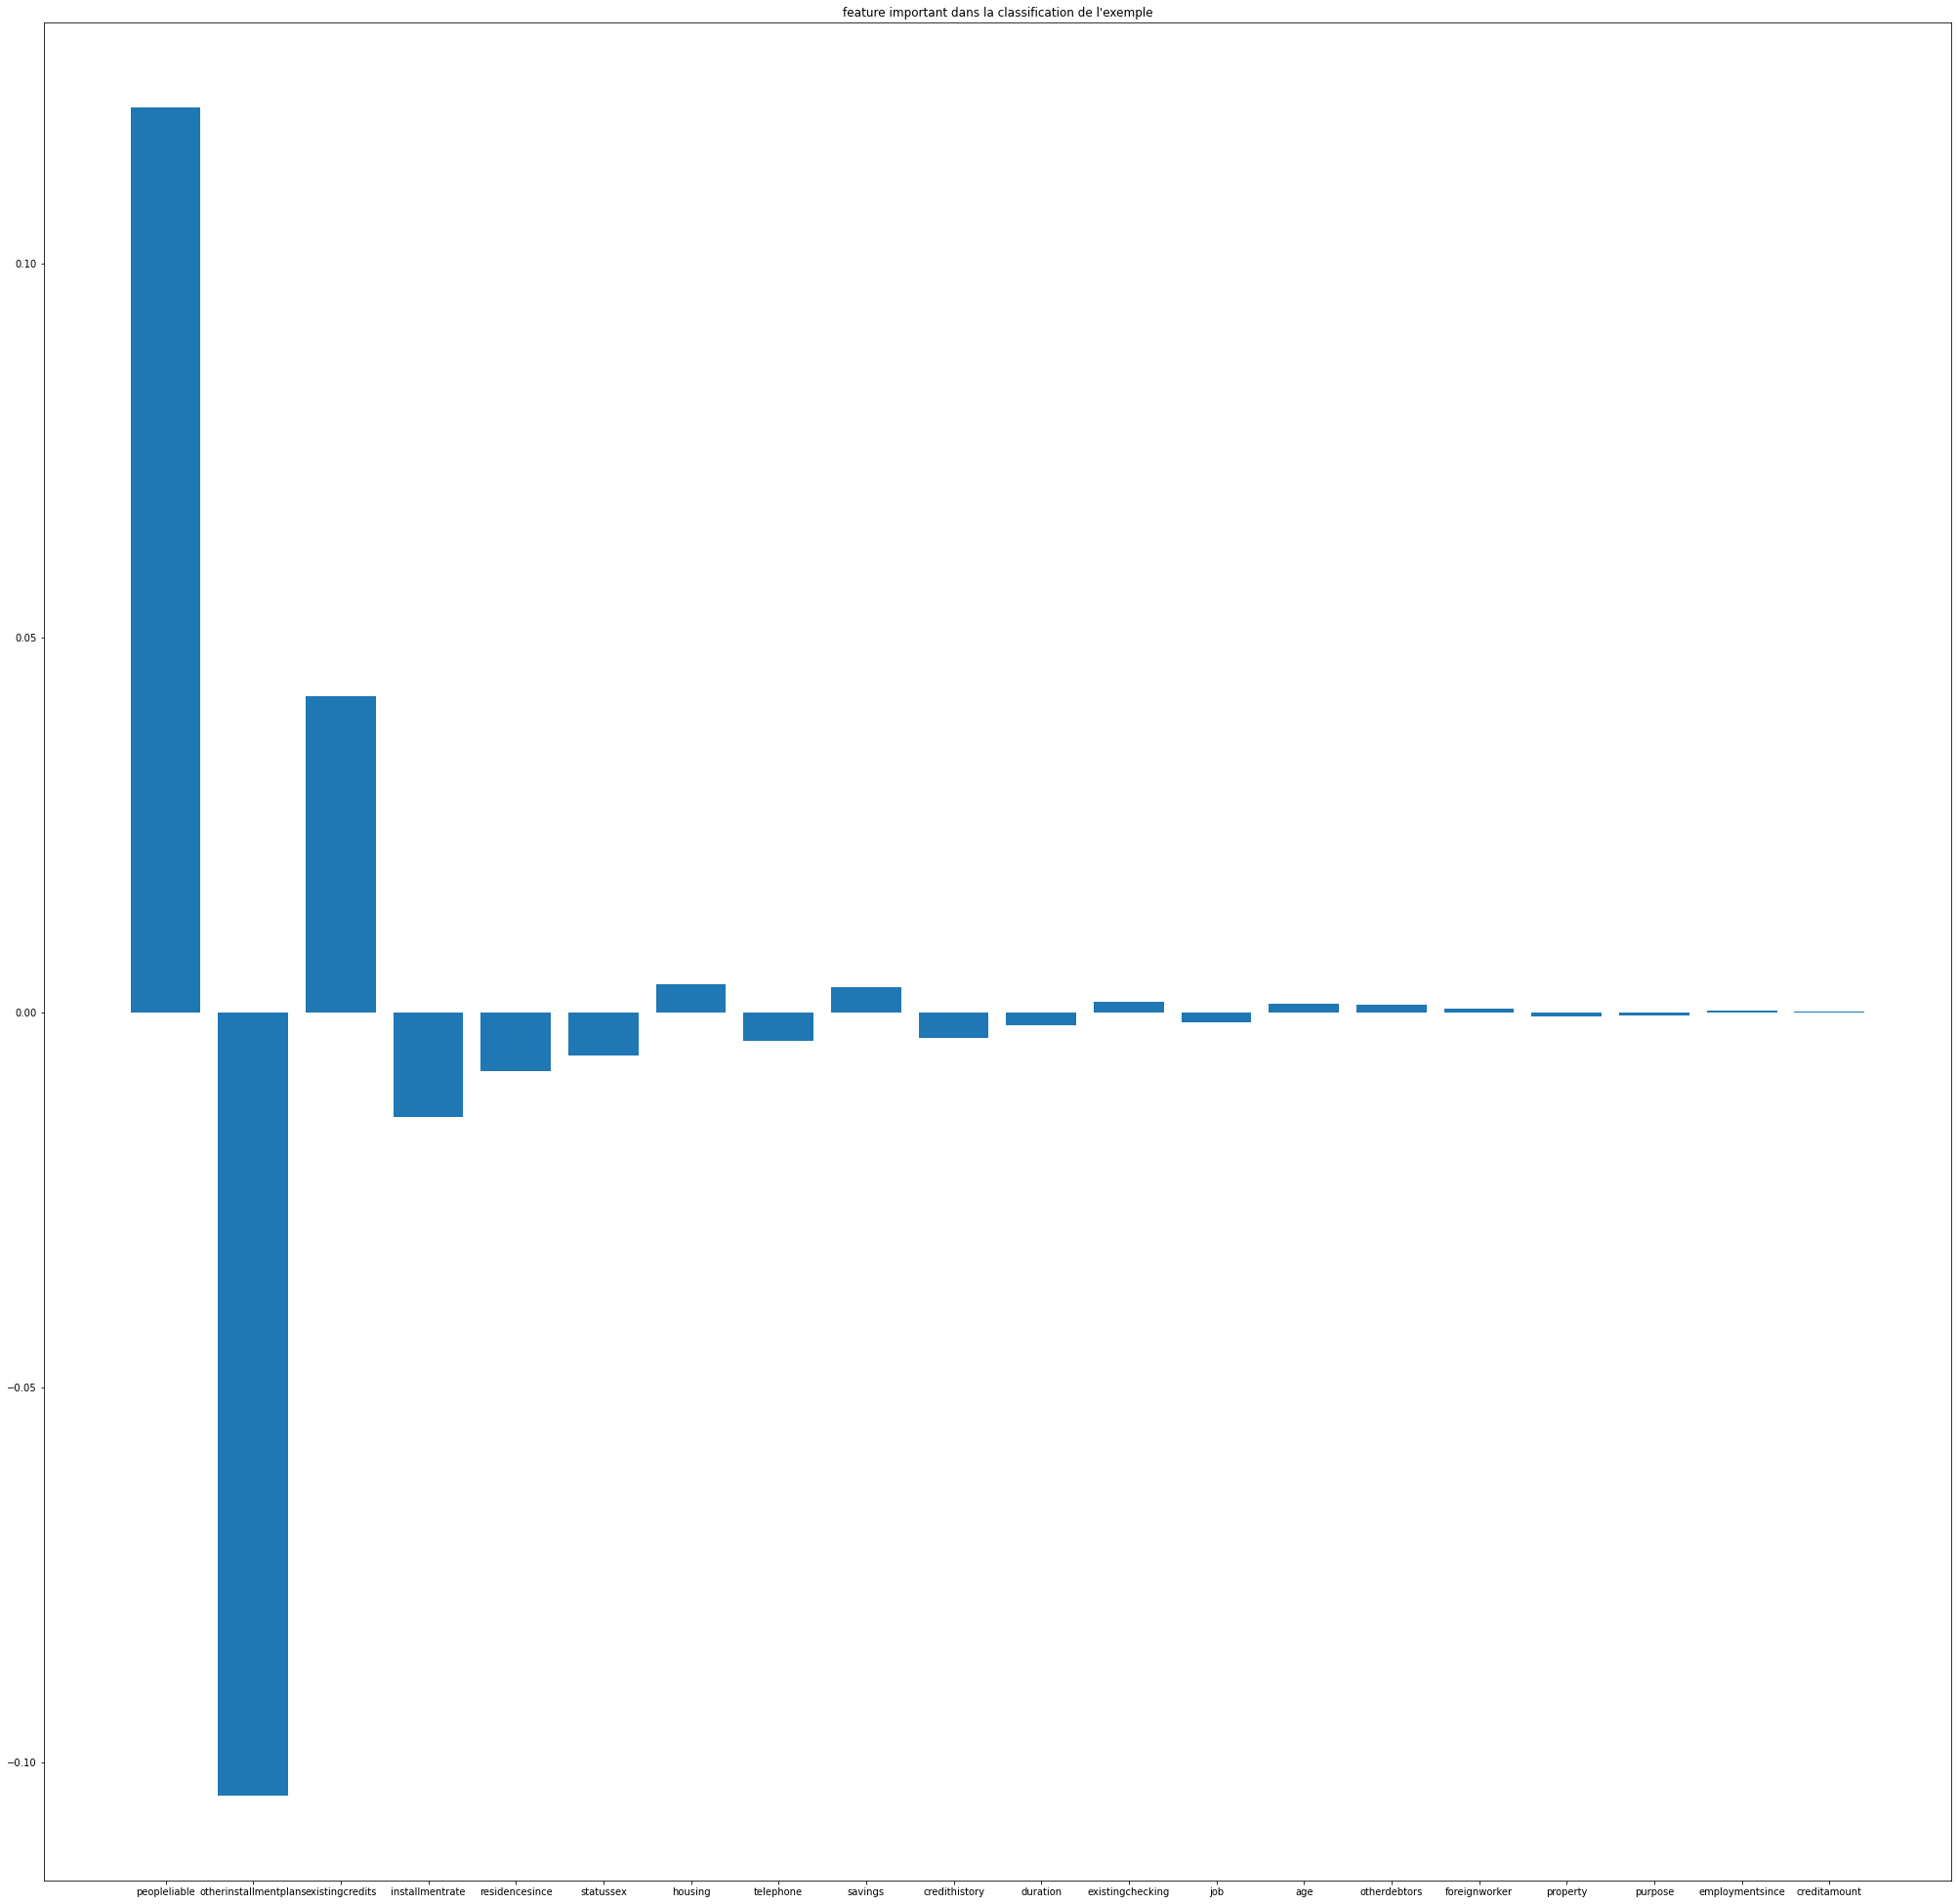

In [62]:
xx=[]
yy=[]
#print(xtotal/len(Xnorm))
#print(ytotal)
xtotnorm=xtotal/len(Xnorm)
featuremax= np.argsort(np.abs(xtotnorm), axis=0)#sort les index triés
#print(featuremax)
for i in range(len(featuremax)):
    
    #print(ytotal[featuremax[-i-1]])
    #print(xtotnorm[featuremax[-i-1]])
    xx.append(xtotnorm[featuremax[-i-1]])
    yy.append(ytotal[featuremax[-i-1]])
#print(xx)
#print(yy)
plt.figure(figsize=(40,40))
plt.bar(yy, xx)
plt.title("feature important dans la classification de l'exemple")
plt.show()